# Libraries Setup

In [1]:
import os
#os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import pandas as pd
from PIL import ImageFont

from geexhp import datasetup as dset
from geexhp import datavis, cnn1d
datavis.configure_matplotlib()

from sklearn.model_selection import train_test_split
import visualkeras
from tensorflow.keras.utils import plot_model # type: ignore

# Data Setup

In [2]:
#folder = "../parallel/data/"
#df = dset.combine_parquet(folder=folder, keyword="_", output_file=True)

In [3]:
df = pd.read_parquet("../data/__data.parquet")

In [4]:
dfabun = dset.extract_abundances(df)
dfabun.dropna(inplace=True)

# Preprocessing data and creating the training and testing datasets

In [5]:
X = np.array([np.array(d) for d in dfabun['ALBEDO'].to_numpy()])
y = dfabun[["ATMOSPHERE-PRESSURE","ATMOSPHERE-TEMPERATURE", "OBJECT-DIAMETER", 
            "OBJECT-GRAVITY","C2H6","CH4","CO","CO2","H2","H2O","HCN","N2",
            "N2O","NH3","O2","O3","PH3"]]
wavelengths = dfabun["WAVELENGTH"][0]

In [6]:
start_wavelength = wavelengths.min()
end_wavelength = wavelengths.max()
num_bins = 10

bin_size = (end_wavelength - start_wavelength) / num_bins
wavelength_bins = [(start_wavelength + i * bin_size, start_wavelength + (i + 1) * bin_size) for i in range(num_bins)]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, _, y_scaler = dset.windowed_normalization(
    X_train, X_test, y_train, y_test, wavelengths, wavelength_bins
)

Train input shape: (31800, 2304, 1)
Test input shape: (7951, 2304, 1)
Train labels shape: (31800, 17)
Test labels shape: (7951, 17)


# Convolutional Neural Network 1D (CNN) 

In [10]:
input_shape = X_train_scaled.shape[1:]
output_units = y_train_scaled.shape[1]
conv_layers = [(32, 3), (64, 3), (128, 3)]
dense_layers = [128, 64]

cnn = cnn1d.ConvolutionalNetwork(input_shape, output_units, conv_layers, dense_layers, dropout_rate=0.3)

In [12]:
history = cnn.train(X_train_scaled, y_train_scaled, epochs=100, batch_size=64)

Epoch 1/100
398/398 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - loss: 1.1080
Epoch 1: saving model to ../models/weights.weights.h5
398/398 ━━━━━━━━━━━━━━━━━━━━ 237s 590ms/step - loss: 1.1078 - val_loss: 0.8846 - learning_rate: 1.0000e-04
Epoch 2/100
398/398 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - loss: 0.9319
Epoch 2: saving model to ../models/weights.weights.h5
398/398 ━━━━━━━━━━━━━━━━━━━━ 246s 619ms/step - loss: 0.9320 - val_loss: 0.8104 - learning_rate: 1.1220e-04
Epoch 3/100
398/398 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - loss: 0.9544
Epoch 3: saving model to ../models/weights.weights.h5
398/398 ━━━━━━━━━━━━━━━━━━━━ 254s 639ms/step - loss: 0.9545 - val_loss: 0.8118 - learning_rate: 1.2589e-04
Epoch 4/100
398/398 ━━━━━━━━━━━━━━━━━━━━ 0s 605ms/step - loss: 0.9401
Epoch 4: saving model to ../models/weights.weights.h5
398/398 ━━━━━━━━━━━━━━━━━━━━ 253s 635ms/step - loss: 0.9402 - val_loss: 0.7885 - learning_rate: 1.4125e-04
Epoch 5/100
398/398 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - loss: 0.9705
Epoch 

KeyboardInterrupt: 

In [9]:
cnn.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Albedo (InputLayer) │ (None, 2304, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 2304, 32)  │        192 │ Albedo[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 128)       │          0 │ conv1d[0][0],     │
│                     │                   │            │ conv1d_1[0][0],   │
│                     │                   │            │ conv1d_2[0][0],   │
│                     │                   │            │ dense[0][0],      │
│                     │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 1152, 32)  │          0 │ re_lu[0][0]       │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1152, 64)  │     10,304 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 576, 64)   │          0 │ re_lu[1][0]       │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 576, 128)  │     24,704 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 288, 128)  │          0 │ re_lu[2][0]       │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 288, 128)  │     49,280 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 36864)     │          0 │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  9,437,440 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ re_lu[3][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 17)        │      2,193 │ re_lu[4][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 28,671,029 (109.37 MB)

 Trainable params: 9,557,009 (36.46 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,114,020 (72.91 MB)

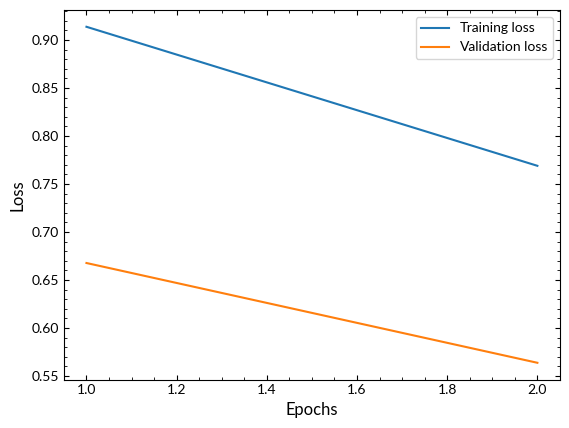

In [10]:
cnn.plot_losses(history)

249/249 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step


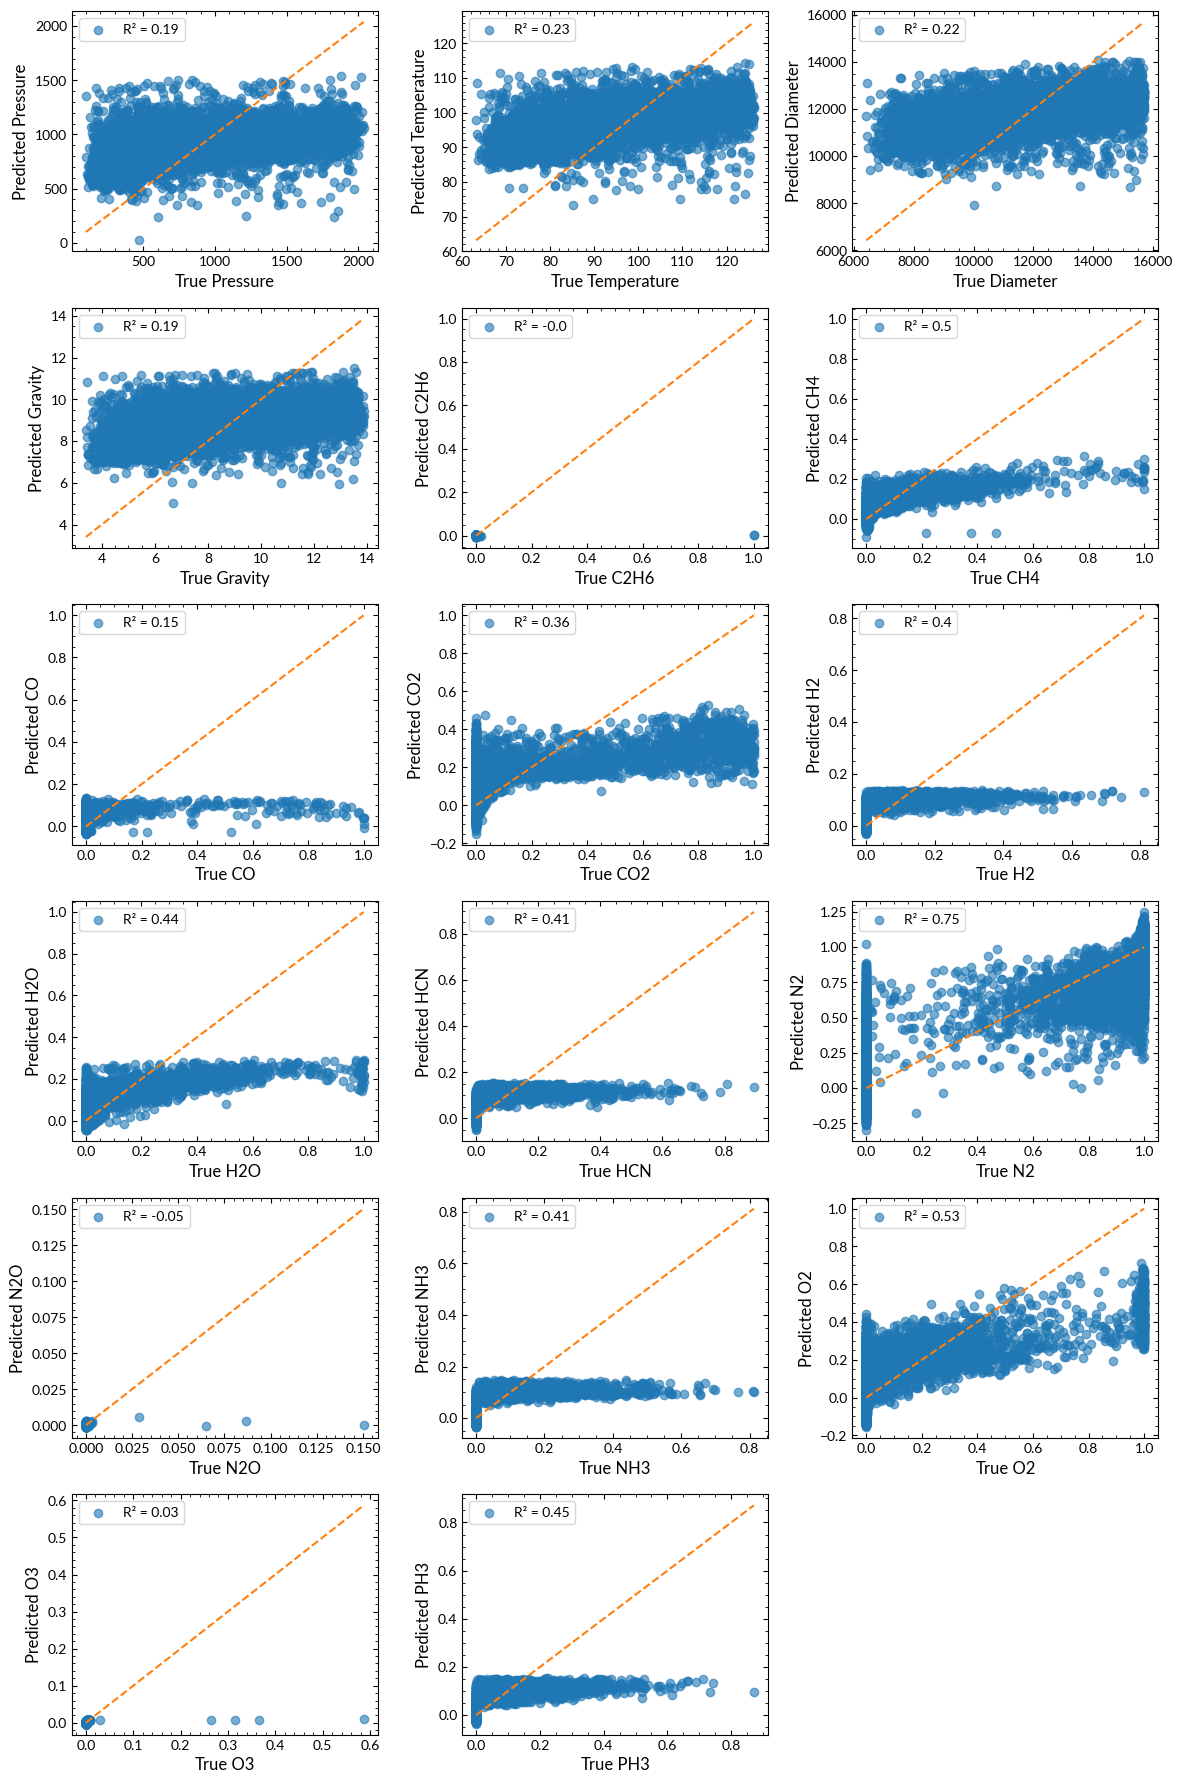

,R² scores,MAE scores,RMSE scores
Pressure,0.19,378.85,450.11
Temperature,0.23,11.72,13.96
Diameter,0.22,1711.23,2038.94
Gravity,0.19,2.01,2.38
C2H6,-0.00,0.00,0.02
CH4,0.50,0.04,0.08
CO,0.15,0.02,0.07
CO2,0.36,0.12,0.18
H2,0.40,0.03,0.06
H2O,0.44,0.06,0.10


In [11]:
features_names = ["Pressure", "Temperature", "Diameter", "Gravity", "C2H6","CH4",
                "CO","CO2","H2","H2O","HCN","N2","N2O","NH3", "O2","O3","PH3"]
cnn.evaluate(X_test_s, y_test_s, features_names, output_scaler)

In [12]:
cnn.save("../models/cnn1d")

INFO:tensorflow:Assets written to: ../models/cnn1d/assets


INFO:tensorflow:Assets written to: ../models/cnn1d/assets


Saved artifact at '../models/cnn1d'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 2304, 1), dtype=tf.float32, name='Albedo')
Output Type:
  TensorSpec(shape=(None, 17), dtype=tf.float32, name=None)
Captures:
  135482899962816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135482900311984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135482900301600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135482900303536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135482900308464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135481647344528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135481647346992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135481647341008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135481647348048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135481647349280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135481647349456: TensorS

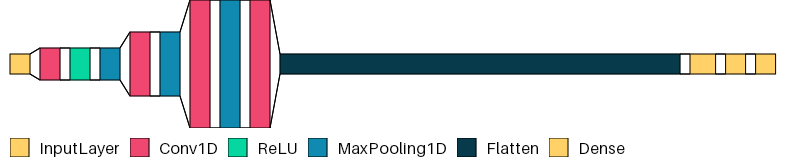

In [19]:
font = ImageFont.load_default(size = 16)

visualkeras.layered_view(cnn.model, to_file='../images/model_architecture.png', legend=True,
                        draw_funnel=True, draw_volume=False,
                        one_dim_orientation="z", scale_xy=1, font=font)

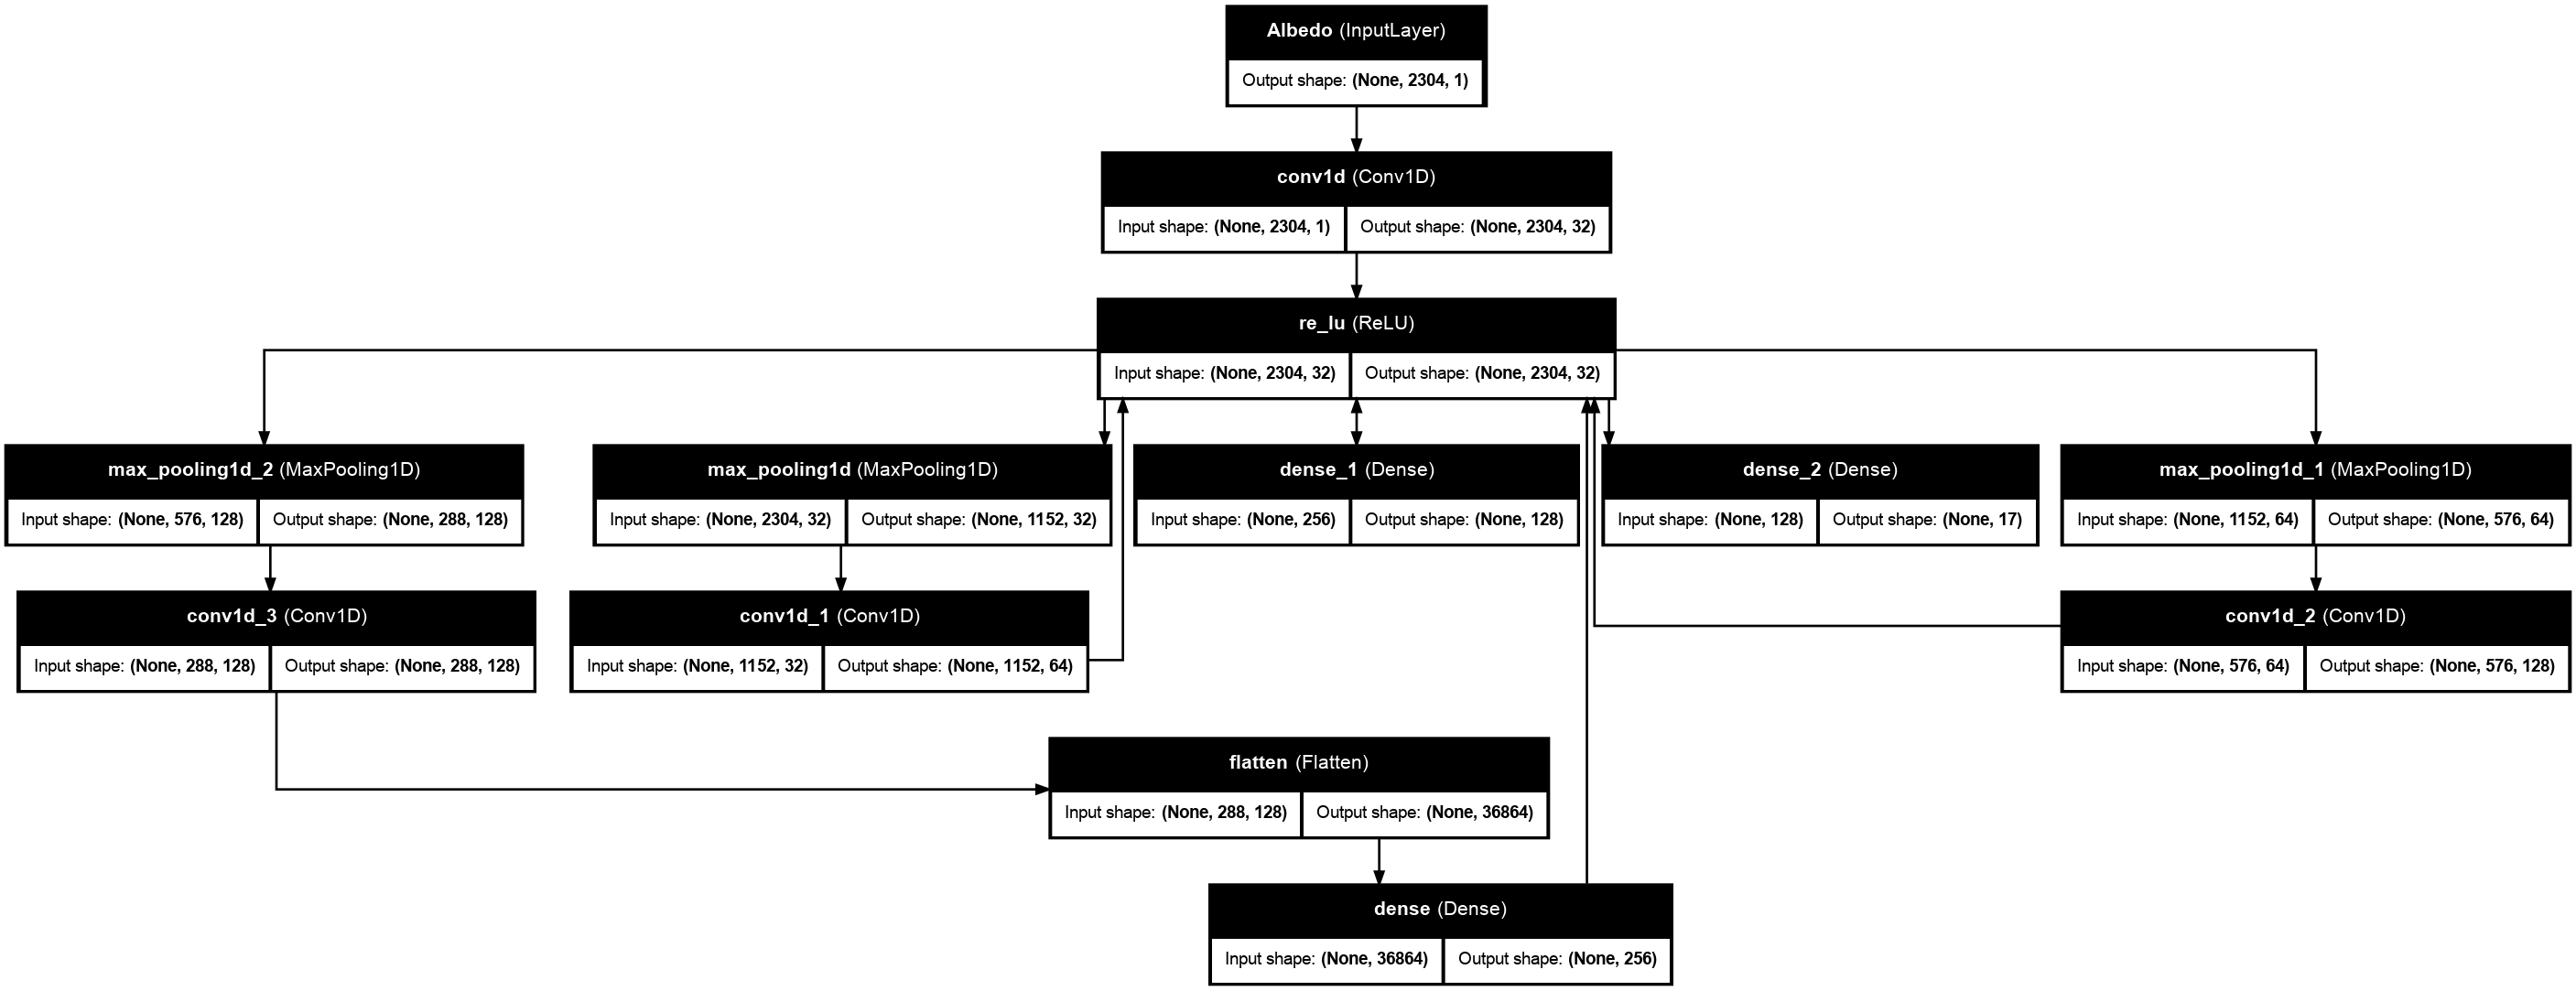

In [16]:
plot_model(cnn.model, to_file='../images/model.png', show_shapes=True, show_layer_names=True,  rankdir='TB', expand_nested=False, dpi=96)

# Tuning hyperparameters

In [7]:
#tuner_cnn = cnn1d.CNNHyperparameterTuner(input_shape, output_units)
#tuner = tuner_cnn.tune(X_train_s, y_train_s, executions_per_trial=10, max_trials=20, epochs=50)

Trial 4 Complete [02h 11m 22s]
val_loss: 0.2340014785528183

Best val_loss So Far: 0.2340014785528183
Total elapsed time: 04h 25m 37s

Search: Running Trial #5

Value             |Best Value So Far |Hyperparameter
1                 |5                 |num_conv_layers
256               |128               |filters_0
5                 |3                 |kernel_size_0
0.2               |0.1               |dropout_rate_0
1                 |3                 |num_dense_layers
256               |448               |units_0
0.2               |0.1               |dense_dropout_rate_0
0.00028337        |0.0013581         |learning_rate
192               |256               |filters_1
5                 |5                 |kernel_size_1
0                 |0                 |dropout_rate_1
64                |160               |filters_2
3                 |3                 |kernel_size_2
0.3               |0.4               |dropout_rate_2
320               |512               |units_1
0.2            

: 

In [ ]:
#best_model = tuner.get_best_models(num_models=1)[0]

In [ ]:
#best_model.summary()